In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import keras as keras
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import datasets, layers, models, regularizers

In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/gdrive/MyDrive/Waste_Classification/Dataset_Resized"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [3]:
batch_size = 32
img_height = 300
img_width = 300
data_dir = '/content/gdrive/MyDrive/Waste_Classification/Dataset_Resized'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  shuffle=True,
  seed=42,
  smart_resize=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 9 classes.
Using 3059 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  shuffle=True,
  seed=42,
  smart_resize=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 9 classes.
Using 1310 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Aluminium', 'Cardboard', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']


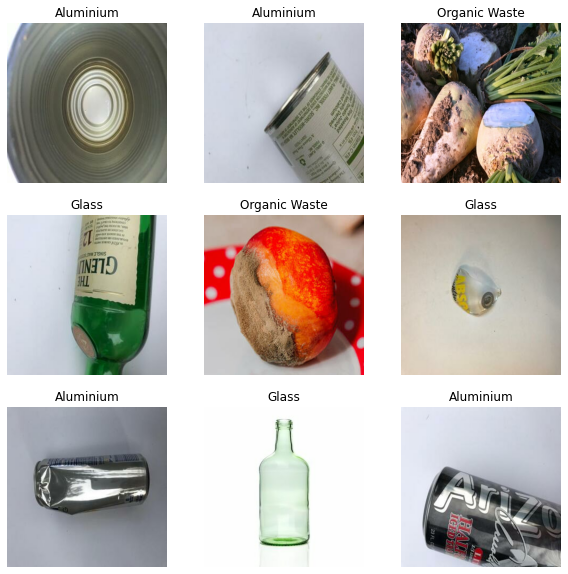

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 341056)            0

In [10]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [11]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

41/41 [==============================] - 105s 2s/step - loss: 2.2338 - accuracy: 0.0534
initial loss: 2.23
initial accuracy: 0.05


In [12]:
history = model.fit(train_ds, epochs=10, 
                    validation_data=(val_ds))

Epoch 1/10
96/96 [==============================] - 205s 2s/step - loss: 3.3382 - accuracy: 0.2592 - val_loss: 1.8311 - val_accuracy: 0.2786
Epoch 2/10
96/96 [==============================] - 13s 135ms/step - loss: 1.4769 - accuracy: 0.4707 - val_loss: 1.5867 - val_accuracy: 0.4580
Epoch 3/10
96/96 [==============================] - 13s 133ms/step - loss: 1.0868 - accuracy: 0.6296 - val_loss: 1.3976 - val_accuracy: 0.5450
Epoch 4/10
96/96 [==============================] - 13s 135ms/step - loss: 0.6821 - accuracy: 0.7833 - val_loss: 1.4669 - val_accuracy: 0.5389
Epoch 5/10
96/96 [==============================] - 13s 134ms/step - loss: 0.4067 - accuracy: 0.8810 - val_loss: 1.7949 - val_accuracy: 0.5267
Epoch 6/10
96/96 [==============================] - 13s 135ms/step - loss: 0.3507 - accuracy: 0.9091 - val_loss: 2.2054 - val_accuracy: 0.5084
Epoch 7/10
96/96 [==============================] - 13s 133ms/step - loss: 0.1900 - accuracy: 0.9464 - val_loss: 2.3830 - val_accuracy: 0.4580
E

41/41 - 3s - loss: 2.7038 - accuracy: 0.5229 - 3s/epoch - 78ms/step


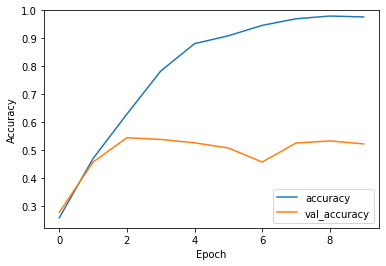

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds, verbose=2)

In [14]:
print(test_acc)

0.5229007601737976


In [15]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 33
Number of test batches: 8


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(mode="horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
       layers.RandomFlip(mode="vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(40),
    layers.RandomZoom(0.4),
    #layers.RandomCrop(170, 170, 3),
    #layers.RandomContrast(0.4)
  ]
)

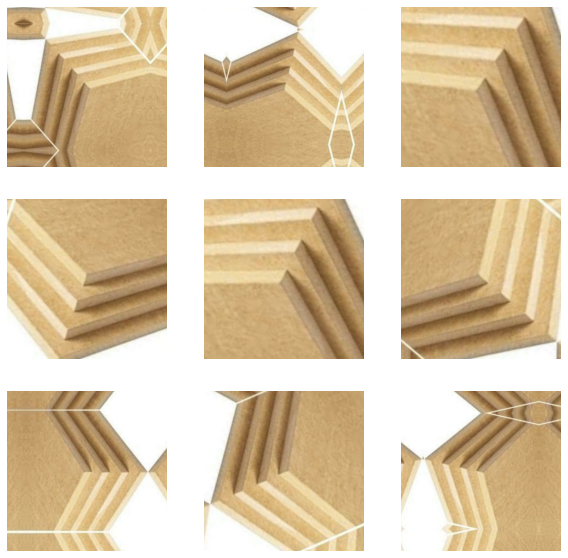

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(512, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5),
    activation ="relu"),
  layers.Dense(num_classes, activation = 'softmax')  
])

In [20]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                  

In [22]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/30
96/96 [==============================] - 22s 197ms/step - loss: 3.7695 - accuracy: 0.2445 - val_loss: 2.6762 - val_accuracy: 0.2856
Epoch 11/30
96/96 [==============================] - 19s 189ms/step - loss: 2.4638 - accuracy: 0.3321 - val_loss: 2.2603 - val_accuracy: 0.3605
Epoch 12/30
96/96 [==============================] - 19s 189ms/step - loss: 2.1782 - accuracy: 0.3815 - val_loss: 2.0323 - val_accuracy: 0.4231
Epoch 13/30
96/96 [==============================] - 18s 187ms/step - loss: 2.0197 - accuracy: 0.4328 - val_loss: 1.9047 - val_accuracy: 0.4545
Epoch 14/30
96/96 [==============================] - 19s 188ms/step - loss: 1.9388 - accuracy: 0.4590 - val_loss: 1.9009 - val_accuracy: 0.4886
Epoch 15/30
96/96 [==============================] - 19s 188ms/step - loss: 1.8643 - accuracy: 0.4835 - val_loss: 1.7704 - val_accuracy: 0.5104
Epoch 16/30
96/96 [==============================] - 19s 188ms/step - loss: 1.7736 - accuracy: 0.5185 - val_loss: 1.6898 - val_accuracy:

In [23]:
from keras.metrics import accuracy
accuracy = history_fine.history['accuracy']
val_accuracy = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

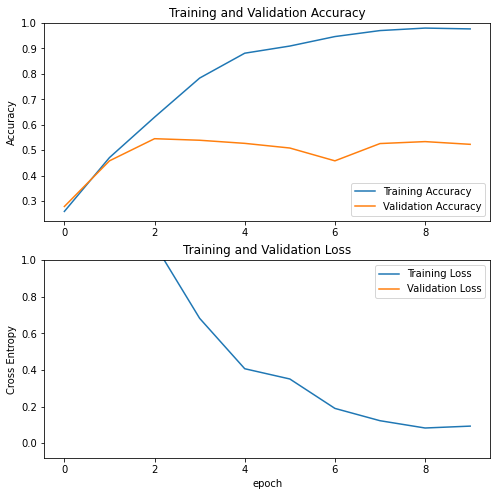

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()